•	EDA: Explore multicollinearity using variance inflation factors, pinpoint heteroscedasticity, and delineate variable relationships.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
branch_level_data = pd.read_csv('data/Branch_Level_Dataset.csv')
branch_level_data.head(5)

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731
3,2022-01-31,Boone High School,1,10,2,8,30,9,80,21,59
4,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551


In [3]:
# Remove rows where BranchCategory is 'High School' or 'Virtual Branch'
branch_level_data = branch_level_data[~branch_level_data['BranchCategory'].str.contains("High School|Virtual Branch")]

# Check for null values in the DataFrame
null_values = branch_level_data.isnull().sum()

# Displaying the DataFrame and the null values information
print(branch_level_data.head())
print(null_values)


  EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
4     2022-01-31                  Clermont  143           482   103    499   
6     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend  
0     5   20                  6             4        14  
1  1589  416               1642           646      3650  
2  2219  560               1983           724      5731  
4  1940  539               1834           580      4551  
6   134   78                227            47       275  
EOM_TRANS_DATE       0
BranchCategory       0
ATM                  0
Bill Payment         0
Cash                 0
Draft                0
ACH                  0
Fee                  0

In [4]:
import pandas as pd

# Load the Excel file
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only the 'County' and 'TOTAL - All Revenue Account Codes' columns
# Assuming these are the first and the third-last columns in your DataFrame
df_revenue = df_revenue.iloc[:, [0, -3]]

# Renaming the columns for clarity
df_revenue.columns = ['County', 'Revenue_Per_County']

# Dropping the first row if it contains headers from the original table
df_revenue = df_revenue.drop(0)

# Displaying the modified DataFrame
print(df_revenue.head())



     County Revenue_Per_County
1   Alachua         1082349199
2     Baker           89157684
3       Bay         1193216378
4  Bradford           85933027
5   Brevard          958971976


In [5]:
import pandas as pd

# Map BranchCategory to County
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

branch_level_data['County'] = branch_level_data['BranchCategory'].map(city_to_county_mapping)

# Load revenue data
file_path = 'data/countyrevenuesbycategory.xlsx'
df_revenue = pd.read_excel(file_path)

# Selecting only 'County' and 'TOTAL - All Revenue Account Codes' columns
df_revenue = df_revenue.iloc[:, [0, -3]]
df_revenue.columns = ['County', 'Revenue_Per_County']
df_revenue = df_revenue.drop(0)

# Merging the DataFrames
branch_level_data = pd.merge(branch_level_data, df_revenue, on='County', how='left')

# Displaying the combined DataFrame
print(branch_level_data.head())


  EOM_TRANS_DATE            BranchCategory  ATM  Bill Payment  Cash  Draft  \
0     2022-01-31  Addition Financial Arena    0             3     0     28   
1     2022-01-31         Altamonte Springs   98           394    64    469   
2     2022-01-31                    Apopka  198           540   132    705   
3     2022-01-31                  Clermont  143           482   103    499   
4     2022-01-31           Downtown Campus   27            35    12     62   

    ACH  Fee  Credit/Debit Card  Home Banking  Dividend    County  \
0     5   20                  6             4        14    Orange   
1  1589  416               1642           646      3650  Seminole   
2  2219  560               1983           724      5731    Orange   
3  1940  539               1834           580      4551      Lake   
4   134   78                227            47       275    Orange   

  Revenue_Per_County  
0         6968835122  
1         1830400546  
2         6968835122  
3         1003940427  
4

            Variable        VIF
0                ATM  31.938006
1       Bill Payment   1.764869
2               Cash  14.574692
3              Draft  57.787527
4                ACH  23.368531
5                Fee  46.443160
6  Credit/Debit Card  32.469875
7       Home Banking  46.801444
8           Dividend  47.148862


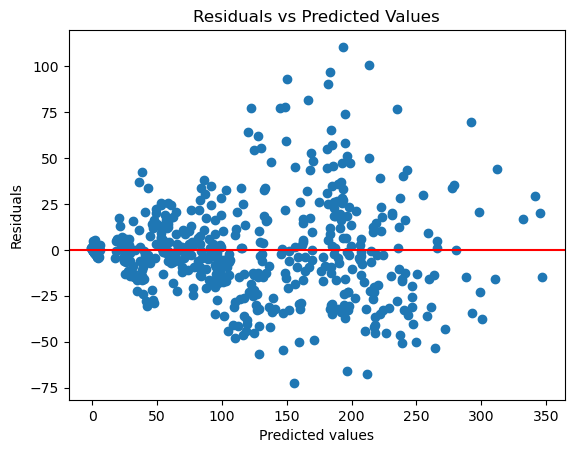

In [6]:
# Creating a copy of branch_level_data for VIF calculation
branch_level_data_copy = branch_level_data.copy()

# Dropping non-numeric columns for VIF calculation
features = branch_level_data_copy.drop(columns=['EOM_TRANS_DATE', 'BranchCategory', 'County', 'Revenue_Per_County'])

vif_data = pd.DataFrame()
vif_data["Variable"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
print(vif_data)

# Dropping a column from the copy for regression analysis
X = features.drop(columns=['ATM'])
y = branch_level_data_copy['ATM']
X = sm.add_constant(X)  # Adding a constant for the intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
residuals = y - predictions

# Plotting Residuals vs Predicted Values
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')  # Adding a horizontal line at y=0 for reference
plt.show()


Variables like "ATM", "Cash", "Draft", "ACH", "Fee", "Credit/Debit Card", "Home Banking", and "Dividend" all have VIF values substantially above 10. This indicates that these variables exhibit high multicollinearity with model.

"Bill Payment" has a VIF value below 5, suggesting that it's not highly collinear with the other variables. How Ironic

Recommendation: Consider dropping or combining some of the variables with high VIF values, or using techniques like regularization, principal component analysis (PCA), or feature selection to handle multicollinearity.

Interpretation:
Ideally, in a homoscedastic distribution, residuals should be scattered randomly around zero, regardless of the predicted values. However, the plot shows a somewhat funnel-shaped pattern, suggesting potential heteroscedasticity.

Recommendation: Consider using weighted least squares (WLS) or transforming the dependent variable (e.g., log transformation) to stabilize the variance of residuals. Also, ensure that the model's assumptions are being met, and outliers aren't influencing the model disproportionately.

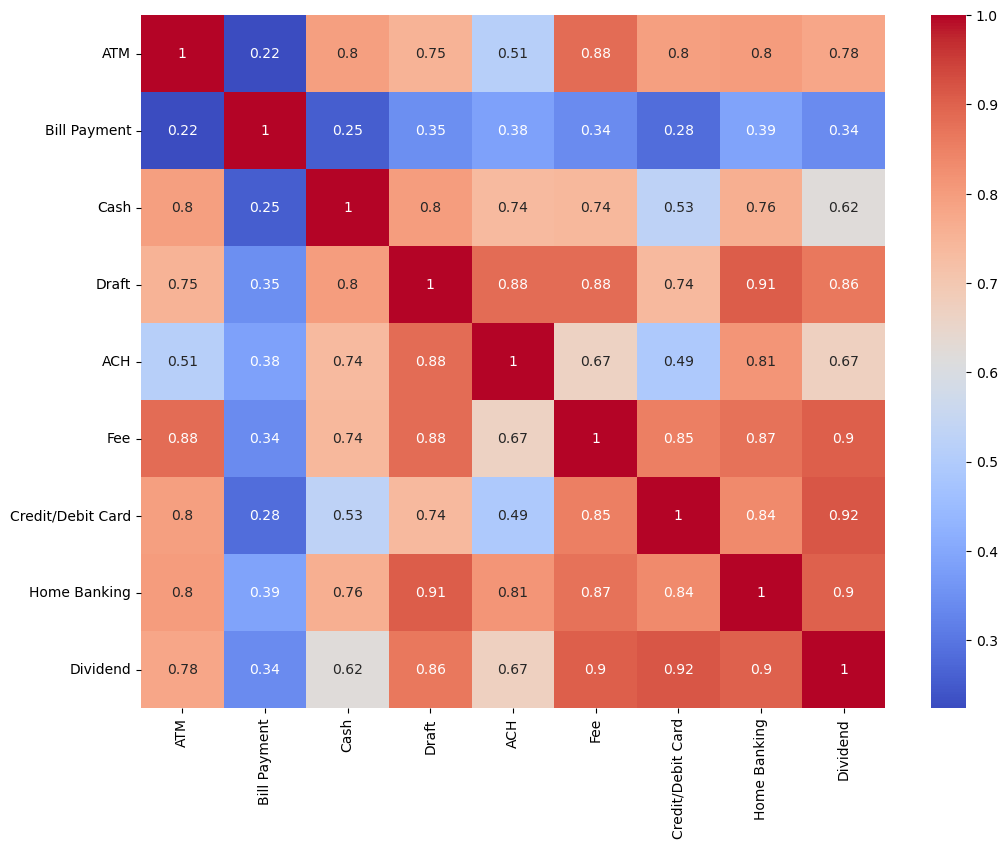

In [7]:
# Using a heatmap to visualize correlations
correlation_matrix = features.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


Many variables have correlations very close to 1 or -1 with other variables, indicating a strong linear relationship between them. For instance, "Draft" and "Fee" have a correlation of 0.92, suggesting they move in the same direction together. (makes sense)

Some variables like "Bill Payment" have relatively lower correlations with other variables, indicating they provide unique information to the model.

Recommendation: Given the strong correlations, you might consider combining some variables, using dimensionality reduction techniques, or choosing a subset of non-highly correlated variables for your analysis.

C:\Users\natet\AppData\Local\Temp\ipykernel_15296\649307579.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  branch_level_data_for_heatmap = branch_level_data_for_heatmap.groupby("BranchCategory").sum()


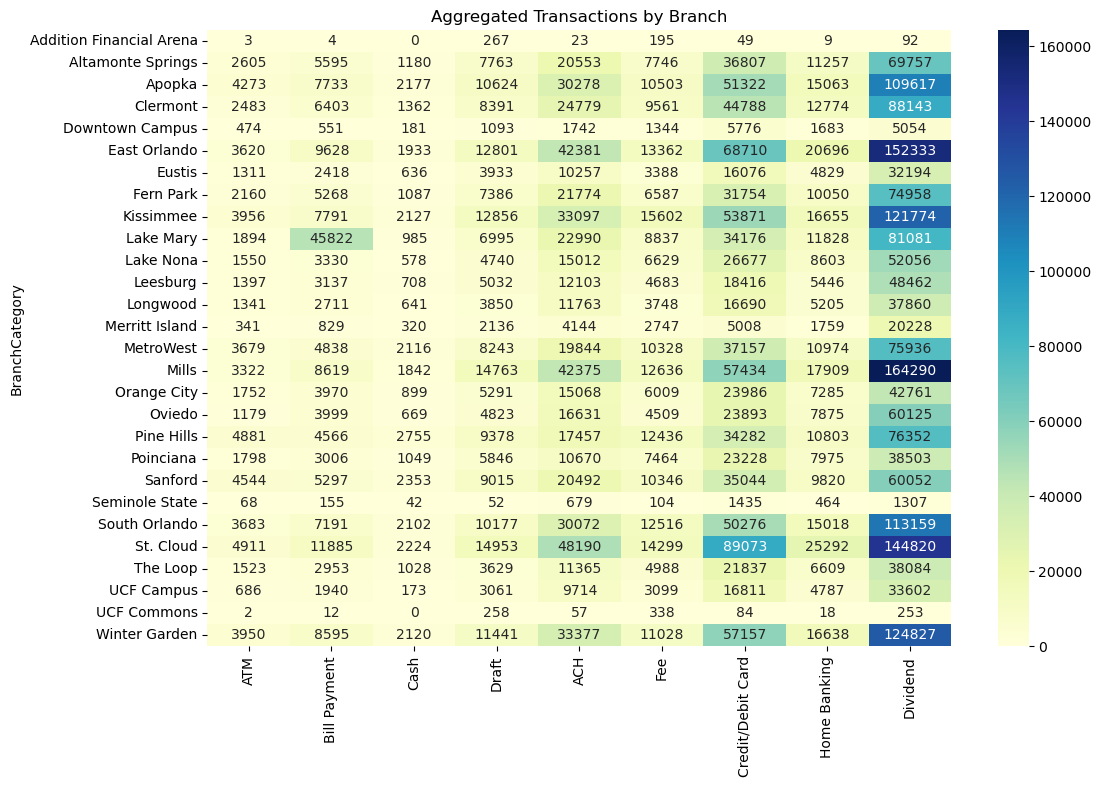

In [8]:
# Creating a separate copy for the heatmap visualization
branch_level_data_for_heatmap = branch_level_data.copy()

# Aggregating data by BranchCategory
branch_level_data_for_heatmap = branch_level_data_for_heatmap.groupby("BranchCategory").sum()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(branch_level_data_for_heatmap, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Aggregated Transactions by Branch")
plt.show()


High Transaction Volume Branches: Branches like "Altamonte Springs", "Kissimmee", "St. Cloud High School", etc., have deeper blue cells, suggesting that they have high transaction volumes for various transaction types.

Specific Transaction Types:

"ATM" transactions seem to have high counts for locations like "Altamonte Springs", "Kissimmee", and "St. Cloud High School".
"Credit/Debit Card" transactions are high for "Altamonte Springs", "Ocoee High School", and "St. Cloud High School".
"Draft" transactions show significant counts for "St. Cloud", "Kissimmee", and "Lake Howell High School".
Lower Transaction Volume Branches: Branches like "Addition Financial Arena", "Edgewater High School", and "UCF Commons" have lighter colors, indicating lower transaction counts across most transaction types.

Uniformity in Transactions: Some branches, like "Fern Park" and "Virtual Branch", show a somewhat uniform color across transaction types, indicating that their transaction distribution is more balanced.

Outliers or Specific Trends: Some branches have specific high transaction types, like "Lake Mary" having a high count of "Draft" transactions, which stands out compared to its other transaction types.

Sparse Transaction Types: Some transaction types, like "Home Banking", show lighter colors across most branches, suggesting they might not be as popular or frequently used as others.

2022-07-21

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Create a copy of the DataFrame to use for the analysis
branch_level_data_copy = branch_level_data.copy()

# Assuming 'Revenue_Per_County' is a column in branch_level_data, and it's the target variable.
# Also assuming 'EOM_TRANS_DATE', 'BranchCategory', and 'County' are columns that need to be dropped.

# Selecting features and target variable
# Drop non-feature columns and the target 'Revenue_Per_County' column
X = branch_level_data_copy.drop(columns=['Revenue_Per_County', 'EOM_TRANS_DATE', 'BranchCategory', 'County'])
y = branch_level_data_copy['Revenue_Per_County']

# Convert 'Revenue_Per_County' to numeric, in case it's not
y = pd.to_numeric(y, errors='coerce')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Coefficient of Determination (R^2):', r2_score(y_test, y_pred))

# Optionally, print the coefficients for each feature
feature_coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(feature_coefficients)



Mean Squared Error: 5.7093296482929e+18
Coefficient of Determination (R^2): 0.17837355876400895
                    Coefficient
ATM                9.515483e+06
Bill Payment      -7.288733e+05
Cash               8.591188e+06
Draft             -4.390106e+06
ACH                4.879999e+05
Fee               -4.524455e+06
Credit/Debit Card -9.900729e+05
Home Banking      -3.348218e+06
Dividend           1.434641e+06


In [10]:
branch_level_data

,EOM_TRANS_DATE,BranchCategory,ATM,Bill Payment,Cash,Draft,ACH,Fee,Credit/Debit Card,Home Banking,Dividend,County,Revenue_Per_County
0,2022-01-31,Addition Financial Arena,0,3,0,28,5,20,6,4,14,Orange,6968835122
1,2022-01-31,Altamonte Springs,98,394,64,469,1589,416,1642,646,3650,Seminole,1830400546
2,2022-01-31,Apopka,198,540,132,705,2219,560,1983,724,5731,Orange,6968835122
3,2022-01-31,Clermont,143,482,103,499,1940,539,1834,580,4551,Lake,1003940427
4,2022-01-31,Downtown Campus,27,35,12,62,134,78,227,47,275,Orange,6968835122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2023-07-31,South Orlando,158,396,130,615,2166,661,2600,752,6210,Orange,6968835122
518,2023-07-31,St. Cloud,208,623,145,846,3279,779,4750,1269,8096,Osceola,1592120547
519,2023-07-31,The Loop,66,155,68,210,871,287,1206,378,2218,Osceola,1592120547
520,2023-07-31,UCF Campus,30,92,11,153,715,192,839,250,1867,Orange,6968835122


In [11]:
# Let's first reload the data as the environment has been reset.

# Assuming 'BranchCategory' uniquely identifies each branch
branch_count = branch_level_data.groupby('County')['BranchCategory'].nunique()
branch_count.name = 'Branch_Count'

# Aggregate the transaction data by the 'County' column, summing up all the transaction-related columns
county_transactions_agg = branch_level_data.groupby('County').agg({
    'ATM': 'sum',
    'Bill Payment': 'sum',
    'Cash': 'sum',
    'Draft': 'sum',
    'ACH': 'sum',
    'Fee': 'sum',
    'Credit/Debit Card': 'sum',
    'Home Banking': 'sum',
    'Dividend': 'sum'
}).reset_index()

# Calculate the total transactions per county
county_transactions_agg['Total_Transactions'] = county_transactions_agg.drop('County', axis=1).sum(axis=1)

# Calculate the average transactions per branch for each county
county_transactions_agg = county_transactions_agg.merge(branch_count.reset_index(), on='County')
county_transactions_agg['Average_Transactions_Per_Branch'] = county_transactions_agg['Total_Transactions'] / county_transactions_agg['Branch_Count']

# Display the DataFrame with total and average transactions
county_transactions_agg[['County', 'Total_Transactions', 'Branch_Count', 'Average_Transactions_Per_Branch']]



,County,Total_Transactions,Branch_Count,Average_Transactions_Per_Branch
0,Brevard,37512,1,37512.000000
1,Lake,373110,3,124370.000000
2,Orange,1962206,12,163517.166667
3,Osceola,715392,3,238464.000000
4,Polk,99539,1,99539.000000
5,Seminole,907676,7,129668.000000
6,Volusia,107021,1,107021.000000


     County  Total_Transactions  Branch_Count  Average_Transactions_Per_Branch
3   Osceola              715392             3                    238464.000000
2    Orange             1962206            12                    163517.166667
5  Seminole              907676             7                    129668.000000
1      Lake              373110             3                    124370.000000
6   Volusia              107021             1                    107021.000000
4      Polk               99539             1                     99539.000000
0   Brevard               37512             1                     37512.000000


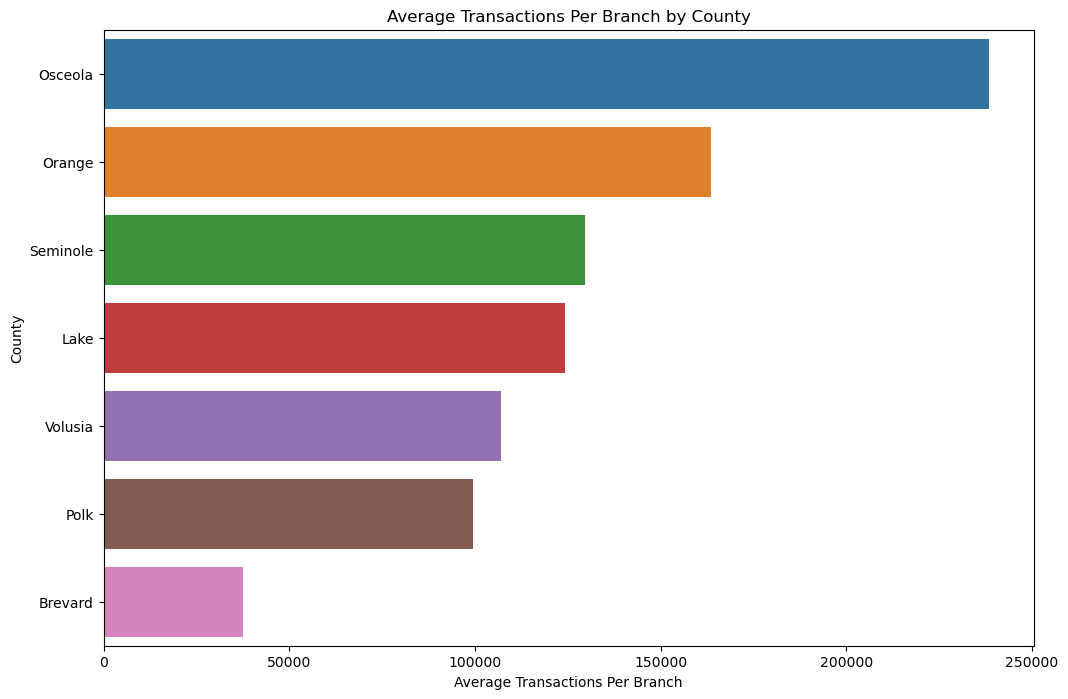

In [12]:
# Sorting counties by the average transactions per branch
county_transactions_agg_sorted = county_transactions_agg.sort_values(by='Average_Transactions_Per_Branch', ascending=False)

# Displaying the counties with their average transaction data per branch
print(county_transactions_agg_sorted[['County', 'Total_Transactions', 'Branch_Count', 'Average_Transactions_Per_Branch']])

# Visualization - Average Transactions per Branch by County
plt.figure(figsize=(12, 8))
sns.barplot(y=county_transactions_agg_sorted['County'], x=county_transactions_agg_sorted['Average_Transactions_Per_Branch'])
plt.title('Average Transactions Per Branch by County')
plt.ylabel('County')
plt.xlabel('Average Transactions Per Branch')
plt.show()


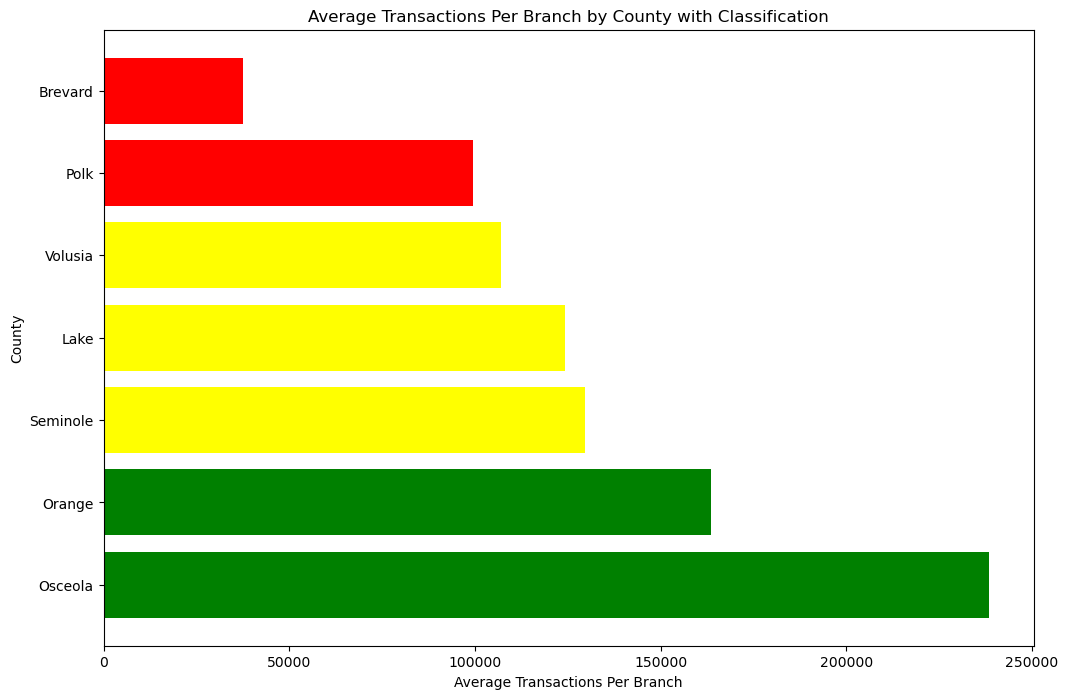

In [13]:
# Define classification thresholds
high_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.75) # top 25%
medium_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.25) # bottom 25%

# Classify counties
county_transactions_agg_sorted['Classification'] = 'Low'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= high_threshold, 'Classification'] = 'High'

# Visualize the classified data
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}
plt.figure(figsize=(12, 8))
plt.barh(county_transactions_agg_sorted['County'], county_transactions_agg_sorted['Average_Transactions_Per_Branch'], color=[colors[cls] for cls in county_transactions_agg_sorted['Classification']])
plt.title('Average Transactions Per Branch by County with Classification')
plt.xlabel('Average Transactions Per Branch')
plt.ylabel('County')
plt.show()


In [14]:
import requests

def get_coordinates(county_name):
    county_name_formatted = county_name.replace(' ', '+') + ',+Florida'
    url = f"https://nominatim.openstreetmap.org/search?q={county_name_formatted}&format=json"
    response = requests.get(url)
    data = response.json()
    latitude = data[0]['lat']
    longitude = data[0]['lon']
    return latitude, longitude

# List of counties
counties = ['Orange', 'Seminole', 'Lake', 'Osceola', 'Brevard', 'Volusia', 'Polk']

# Fetching and printing coordinates for each county
for county in counties:
    latitude, longitude = get_coordinates(county + ' County')
    print(f"The coordinates for {county} County are Latitude: {latitude} and Longitude: {longitude}")



The coordinates for Orange County are Latitude: 28.5421109 and Longitude: -81.3790304
The coordinates for Seminole County are Latitude: 28.7225829 and Longitude: -81.2353683
The coordinates for Lake County are Latitude: 28.7006859 and Longitude: -81.78994
The coordinates for Osceola County are Latitude: 28.0443842 and Longitude: -81.1437541
The coordinates for Brevard County are Latitude: 28.2100203 and Longitude: -80.7997185
The coordinates for Volusia County are Latitude: 29.0533409 and Longitude: -81.1310761
The coordinates for Polk County are Latitude: 27.9448537 and Longitude: -81.7268789


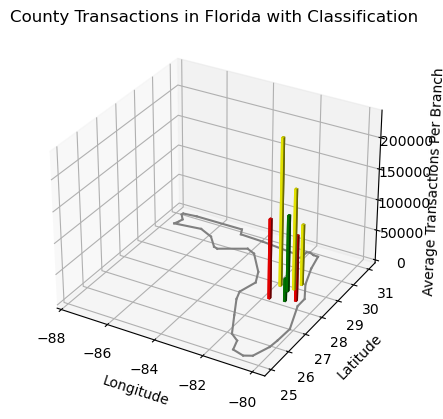

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load the US states shapefile (make sure the path is correct)
states = gpd.read_file('Florida_shape/ne_110m_admin_1_states_provinces.shp')
florida = states[states['name'] == 'Florida']
florida_boundary = florida.geometry.values[0].exterior.coords.xy
florida_x = list(florida_boundary[0])
florida_y = list(florida_boundary[1])

County_Coordinates = {
    'Osceola': (28.0443842, -81.1437541),
    'Orange': (28.5421109, -81.3790304),
    'Seminole': (28.7225829, -81.2353683),
    'Lake': (28.7006859, -81.78994),
    'Volusia': (29.0533409, -81.1310761),
    'Polk': (27.9448537, -81.7268789),
    'Brevard': (28.2100203, -80.7997185)
}

# Define classification thresholds and colors
high_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.75)
medium_threshold = county_transactions_agg_sorted['Average_Transactions_Per_Branch'].quantile(0.25)
county_transactions_agg_sorted['Classification'] = 'Low'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= medium_threshold, 'Classification'] = 'Medium'
county_transactions_agg_sorted.loc[county_transactions_agg_sorted['Average_Transactions_Per_Branch'] >= high_threshold, 'Classification'] = 'High'
colors = {'Low': 'red', 'Medium': 'yellow', 'High': 'green'}

# Extract x, y, z data for counties
x = [County_Coordinates[county][1] for county in county_transactions_agg_sorted['County']]  # longitude
y = [County_Coordinates[county][0] for county in county_transactions_agg_sorted['County']]  # latitude
z = county_transactions_agg_sorted['Average_Transactions_Per_Branch']
color_map = [colors[cls] for cls in county_transactions_agg_sorted['Classification']]

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the shape of Florida
for i in range(len(florida_x) - 1):
    ax.plot([florida_x[i], florida_x[i+1]], 
            [florida_y[i], florida_y[i+1]], 
            [0, 0], color='gray')

# Plot each county's data as a colored pillar
for i in range(len(x)):
    ax.bar3d(x[i], y[i], 0, 0.1, 0.1, z[i], color=color_map[i], shade=True)

# Labeling and titles
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Average Transactions Per Branch')
ax.set_title('County Transactions in Florida with Classification')

plt.show()



Next step get all the coord then do the classification with all cities 

In [ ]:
branch_level_data